In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
from tqdm import tqdm
from scipy.stats import pearsonr
from multiprocessing import Process, Pool
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def convert_temporal_data(dataframe):
  '''
  Convert temporal variables from seconds to hours.

  This conversion is necessary. Otherwise, large predictor values (e.g., p^6)
  will be irrelevant for OLS.
  '''

  for column in ['p', 'r']:
    dataframe[column] = dataframe[column] / 3600

  return dataframe

def read_score_distribution(csv_file):
  columns = ['p', 'q', 'r', 'score']
  distribution = pd.read_csv(csv_file, names=columns,skiprows=1)
  distribution = convert_temporal_data(distribution)
  return distribution
def read_score_distribution_2(csv_file):
  columns = ['p', 'q', 'r','x','w','z', 'score']
  distribution = pd.read_csv(csv_file, names=columns,skiprows=1)
  distribution = convert_temporal_data(distribution)

  return distribution

In [3]:
def add_quadratic_predictors(dataframe):
  dataframe[['p2', 'q2', 'r2']] = dataframe[['p', 'q', 'r']]**2
  dataframe['pq'] = dataframe['p']*dataframe['q']

  return dataframe

def add_cubic_predictors(dataframe):
  dataframe[['p3', 'q3', 'r3']] = dataframe[['p', 'q', 'r']]**3
  dataframe['p2q'] = dataframe['p']**2 * dataframe['q']
  dataframe['pq2'] = dataframe['p'] * dataframe['q']**2

  return dataframe

def add_quartic_predictiors(dataframe):
  dataframe[['p4', 'q4', 'r4']] = dataframe[['p', 'q', 'r']]**4
  dataframe['p3q'] = dataframe['p']**3 * dataframe['q']
  dataframe['p2q2'] = dataframe['p']**2 * dataframe['q']**2
  dataframe['pq3'] = dataframe['p'] * dataframe['q']**3

  return dataframe

def add_quintic_predictors(dataframe):
  dataframe[['p5', 'q5', 'r5']] = dataframe[['p', 'q', 'r']]**5
  dataframe['p4q'] = dataframe['p']**4 * dataframe['q']
  dataframe['p3q2'] = dataframe['p']**3 * dataframe['q']**2
  dataframe['p2q3'] = dataframe['p']**2 * dataframe['q']**3
  dataframe['pq4'] = dataframe['p'] * dataframe['q']**4

  return dataframe

def add_sextic_predictors(dataframe):
  dataframe[['p6', 'q6', 'r6']] = dataframe[['p', 'q', 'r']]**6
  dataframe['p5q'] = dataframe['p']**5 * dataframe['q']
  dataframe['p4q2'] = dataframe['p']**4 * dataframe['q']**2
  dataframe['p3q3'] = dataframe['p']**3 * dataframe['q']**3
  dataframe['p2q4'] = dataframe['p']**2 * dataframe['q']**4
  dataframe['pq5'] = dataframe['p'] * dataframe['q']**5

  return dataframe
def only_att_predictors(dataframe):
    dataframe[['p2', 'q2', 'r2']] = dataframe[['p', 'q', 'r']]**2
    dataframe[['p3', 'q3', 'r3']] = dataframe[['p', 'q', 'r']]**3
    dataframe[['p4', 'q4', 'r4']] = dataframe[['p', 'q', 'r']]**4
    dataframe[['p5', 'q5', 'r5']] = dataframe[['p', 'q', 'r']]**5
    dataframe[['p6', 'q6', 'r6']] = dataframe[['p', 'q', 'r']]**6

    return dataframe
def only_wq_att_predictors(dataframe):
    dataframe[['p2', 'r2']] = dataframe[['p', 'r']]**2
    dataframe[['p3',  'r3']] = dataframe[['p', 'r']]**3
    dataframe[['p4',  'r4']] = dataframe[['p', 'r']]**4
    dataframe[['p5',  'r5']] = dataframe[['p', 'r']]**5
    dataframe[['p6',  'r6']] = dataframe[['p', 'r']]**6

    return dataframe
def only_lin_predictors(dataframe):
    dataframe['pq'] = dataframe['p']*dataframe['q']
    dataframe['p2q'] = dataframe['p']**2 * dataframe['q']
    dataframe['pq2'] = dataframe['p'] * dataframe['q']**2
    dataframe['p3q'] = dataframe['p']**3 * dataframe['q']
    dataframe['p2q2'] = dataframe['p']**2 * dataframe['q']**2
    dataframe['pq3'] = dataframe['p'] * dataframe['q']**3
    dataframe['p4q'] = dataframe['p']**4 * dataframe['q']
    dataframe['p3q2'] = dataframe['p']**3 * dataframe['q']**2
    dataframe['p2q3'] = dataframe['p']**2 * dataframe['q']**3
    dataframe['pq4'] = dataframe['p'] * dataframe['q']**4

    return dataframe
def only_lin_predictors_pr(dataframe):
    dataframe['pr'] = dataframe['p']*dataframe['r']
    dataframe['p2r'] = dataframe['p']**2 * dataframe['r']
    dataframe['pr2'] = dataframe['p'] * dataframe['r']**2
    dataframe['p3r'] = dataframe['p']**3 * dataframe['r']
    dataframe['p2r2'] = dataframe['p']**2 * dataframe['r']**2
    dataframe['p4r'] = dataframe['p']**4 * dataframe['r']
    dataframe['p3r2'] = dataframe['p']**3 * dataframe['r']**2
    dataframe['p2r3'] = dataframe['p']**2 * dataframe['r']**3
    dataframe['pr4'] = dataframe['p'] * dataframe['r']**4

    return dataframe

In [4]:
def create_quadratic_polynomial(dataframe):
  dataframe = add_quadratic_predictors(dataframe)
  return dataframe

def create_cubic_polynomial(dataframe):
  dataframe = add_cubic_predictors(
              add_quadratic_predictors(dataframe))
  return dataframe

def create_quartic_polynomial(dataframe):
  dataframe = add_quartic_predictiors(
              add_cubic_predictors(
              add_quadratic_predictors(dataframe)))
  return dataframe

def create_quintic_polynomial(dataframe):
  dataframe = add_quintic_predictors(
              add_quartic_predictiors(
              add_cubic_predictors(
              add_quadratic_predictors(dataframe))))
  return dataframe

def create_sextic_polynomial(dataframe):
  dataframe = add_sextic_predictors(
              add_quintic_predictors(
              add_quartic_predictiors(
              add_cubic_predictors(
              add_quadratic_predictors(dataframe)))))
  return dataframe

In [8]:
variables = ['p', 'q', 'r']
degre_max = 4

# Générer les combinaisons
possibilites = []
possibilites.append("sqrt(p)")
possibilites.append("sqrt(q)")
possibilites.append("sqrt(r)")
for degre in range(1, degre_max + 1):
    for variable in variables:
        possibilites.append(variable + str(degre))

for degre in range(1, degre_max + 1):
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            possibilites.append(variables[i] + str(degre) + variables[j])
            if degre!=1:
                possibilites.append(variables[j] + str(degre) + variables[i])



# Afficher les combinaisons
print (len(possibilites))

36


In [11]:
variables = ['p', 'q', 'r','x','w','z']
degre_max = 2

# Générer les combinaisons
possibilites_2 = []
possibilites_2.append("sqrt(p)")
possibilites_2.append("sqrt(q)")
possibilites_2.append("sqrt(r)")
possibilites_2.append("sqrt(x)")
possibilites_2.append("sqrt(w)")
possibilites_2.append("sqrt(z)")
for degre in range(1, degre_max + 1):
    for variable in variables:
        possibilites_2.append(variable + str(degre))

for degre in range(1, degre_max + 1):
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):
            possibilites_2.append(variables[i] + str(degre) + variables[j])
            if degre!=1:
                possibilites_2.append(variables[j] + str(degre) + variables[i])



# Afficher les combinaisons
print (len(possibilites_2))

63


In [11]:
import copy
import random

history=[]
names=[]
def grid_search (dataframe, n,threshold):
    best_vif=[100000000000000]*20
    best_set=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    comb=list(itertools.combinations(possibilites,n))
    if n>3:
        comb=random.sample(comb, 5000)
    for var_set in tqdm(comb, desc="Progression :" ):
        df_copy = pd.DataFrame()
        
        # Appliquer les transformations pour chaque variable dans l'ensemble
        for var in var_set:
            
            if var.startswith('sqrt'):
                
                root_var = var[-2]  # Récupérer la variable ('p', 'q' ou 'r') à partir de la variable sqrt
                df_copy[var] = dataframe[root_var].apply(math.sqrt)
                
            elif var.startswith(('p', 'q', 'r'))and len(var)==2:
                power = int(var[1:]) if len(var) > 1 else 1  # Récupérer l'exposant du polynôme
                base_var = var[0]  # Récupérer la variable ('p', 'q' ou 'r') à partir de la variable polynomiale
                df_copy[var] = dataframe[base_var] ** power
            elif var in [ 'p1q', 'p1r', 'q1r']:
                var_1, var_2 = var[0], var[2]  # Récupérer les deux variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = dataframe[var_1]  * dataframe[var_2]
            elif var in ['p2q', 'q2p', 'p2r', 'r2p', 'q2r', 'r2q']:
                var_1, var_2 = var[0], var[2]  # Récupérer les deux variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = (dataframe[var_1] **2) * dataframe[var_2]
            elif var in ['p3q', 'q3p', 'p3r', 'r3p', 'q3r', 'r3q']:
                var_1, var_2 = var[0], var[2]  # Récupérer les trois variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = (dataframe[var_1]**3) * dataframe[var_2] 
            elif var in ['p4q', 'q4p', 'p4r', 'r4p', 'q4r', 'r4q']:
                var_1, var_2 = var[0], var[2] # Récupérer les quatre variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = (dataframe[var_1]**4) * dataframe[var_2]
        res=compute_vif(df_copy)
        max=np.max(res['VIF'])
        history.append(max)
        if n==1 : 
            names.append(var_set[-1])
        else : 
            res= var_set[0]
            for var in var_set:
                if var != var_set[0]:
                    res += "-"+var
            names.append(res)
        b=False
        idx=0
        for best in best_vif:
            if max<best and max>=threshold:
                b=True
                break
            idx+=1
        if b==True:
            tmp_vif=best_vif.copy()
            tmp_set=best_set.copy()
            for i in range (idx+1,5):
                
                tmp_vif[i]=best_vif[i-1]
                tmp_set[i]=best_set[i-1]
            tmp_vif[idx]=max
            tmp_set[idx]=var_set
            best_vif=tmp_vif
            best_set=tmp_set
        
        
            
    with open("grid.csv", "a+") as res:
        res.write(str(n))
        res.write(',')
        res.write(str(best_vif))
        res.write(',')
        res.write(str(best_set))
        res.write('\n')
    print(best_vif)
    print(best_set)


In [26]:
print(possibilites_2)

['sqrt(p)', 'sqrt(q)', 'sqrt(r)', 'sqrt(x)', 'sqrt(w)', 'sqrt(z)', 'p1', 'q1', 'r1', 'x1', 'w1', 'z1', 'p2', 'q2', 'r2', 'x2', 'w2', 'z2', 'p1q', 'p1r', 'p1x', 'p1w', 'p1z', 'q1r', 'q1x', 'q1w', 'q1z', 'r1x', 'r1w', 'r1z', 'x1w', 'x1z', 'w1z', 'p2q', 'q2p', 'p2r', 'r2p', 'p2x', 'x2p', 'p2w', 'w2p', 'p2z', 'z2p', 'q2r', 'r2q', 'q2x', 'x2q', 'q2w', 'w2q', 'q2z', 'z2q', 'r2x', 'x2r', 'r2w', 'w2r', 'r2z', 'z2r', 'x2w', 'w2x', 'x2z', 'z2x', 'w2z', 'z2w']


In [27]:
import copy
import random

history=[]
names=[]
def grid_search_2 (dataframe, n,threshold):
    best_vif=[100000000000000]*20
    best_set=[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
    comb=list(itertools.combinations(possibilites_2,n))
    comb=random.sample(comb, 5000)
    for var_set in tqdm(comb, desc="Progression :" ):
        df_copy = pd.DataFrame()
        
        # Appliquer les transformations pour chaque variable dans l'ensemble
        for var in var_set:
            
            if var.startswith('sqrt'):
                
                root_var = var[-2]  # Récupérer la variable ('p', 'q' ou 'r') à partir de la variable sqrt
                df_copy[var] = dataframe[root_var].apply(math.sqrt)
                
            elif var.startswith(('p', 'q', 'r','x','w','z'))and len(var)==2:
                power = int(var[1:]) if len(var) > 1 else 1  # Récupérer l'exposant du polynôme
                base_var = var[0]  # Récupérer la variable ('p', 'q' ou 'r') à partir de la variable polynomiale
                df_copy[var] = dataframe[base_var] ** power
            elif var in [ 'p1q', 'p1r', 'p1x', 'p1w', 'p1z', 'q1r', 'q1x', 'q1w', 'q1z', 'r1x', 'r1w', 'r1z', 'x1w', 'x1z', 'w1z']:
                var_1, var_2 = var[0], var[2]  # Récupérer les deux variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = dataframe[var_1]  * dataframe[var_2]
            elif var in ['p2q', 'q2p', 'p2r', 'r2p', 'q2r', 'r2q',
                         'x2p', 'x2r', 'x2q','p2x', 'r2x', 'q2x',
                         'w2p', 'w2r', 'w2q','p2w', 'r2w', 'q2w',
                         'z2p', 'z2r', 'z2q','p2z', 'r2z', 'q2z',
                         'x2w', 'x2z', 'w2z','w2x', 'z2x', 'z2w']:
                var_1, var_2 = var[0], var[2]  # Récupérer les deux variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = (dataframe[var_1] **2) * dataframe[var_2]
            elif var in ['p3q', 'q3p', 'p3r', 'r3p', 'q3r', 'r3q',
                         'x3p', 'x3r', 'x3q','p3x', 'r3x', 'q3x',
                         'w3p', 'w3r', 'w3q','p3w', 'r3w', 'q3w',
                         'z3p', 'z3r', 'z3q','p3z', 'r3z', 'q3z',
                         'x3w', 'x3z', 'w3z','w3x', 'z3x', 'z3w']:
                var_1, var_2 = var[0], var[2]  # Récupérer les trois variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = (dataframe[var_1]**3) * dataframe[var_2] 
            elif var in ['p4q', 'q4p', 'p4r', 'r4p', 'q4r', 'r4q',
                         'x4p', 'x4r', 'x4q','p4x', 'r4x', 'q4x',
                         'w4p', 'w4r', 'w4q','p4w', 'r4w', 'q4w',
                         'z4p', 'z4r', 'z4q','p4z', 'r4z', 'q4z',
                         'x4w', 'x4z', 'w4z','w4x', 'z4x', 'z4w']:
                var_1, var_2 = var[0], var[2] # Récupérer les quatre variables ('p', 'q' ou 'r') de la combinaison
                df_copy[var] = (dataframe[var_1]**4) * dataframe[var_2]
        res=compute_vif(df_copy)
        max=np.max(res['VIF'])
        history.append(max)
        if n==1 : 
            names.append(var_set[-1])
        else : 
            res= var_set[0]
            for var in var_set:
                if var != var_set[0]:
                    res += "-"+var
            names.append(res)
        b=False
        idx=0
        for best in best_vif:
            if max<best and max>=threshold:
                b=True
                break
            idx+=1
        if b==True:
            tmp_vif=best_vif.copy()
            tmp_set=best_set.copy()
            for i in range (idx+1,5):
                
                tmp_vif[i]=best_vif[i-1]
                tmp_set[i]=best_set[i-1]
            tmp_vif[idx]=max
            tmp_set[idx]=var_set
            best_vif=tmp_vif
            best_set=tmp_set
        
        
            
    with open("grid.csv", "a+") as res:
        res.write(str(n))
        res.write(',')
        res.write(str(best_vif))
        res.write(',')
        res.write(str(best_set))
        res.write('\n')
    print(best_vif)
    print(best_set)


In [23]:
def compute_vif(features):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    vif['feature'] = features.columns
    return vif

In [13]:
csv_file = "data/global_training_data_GA_MEM.csv"
raw_dist = read_score_distribution_2(csv_file)
print (raw_dist)

               p    q          r            x          w              z  \
0       0.008889   64   6.506389  4026.117647   7.294118   17096.941176   
1      11.181667   16   3.035556  4494.150000  16.000000    7636.950000   
2       4.454167   16   3.927222  5620.916667  31.000000   13235.250000   
3       1.722500  256  20.269722  4610.900000  30.133333   52830.833333   
4       0.020833    1   3.285278  3410.666667  43.333333   11709.000000   
...          ...  ...        ...          ...        ...            ...   
81339   0.015556    8   3.497500  5728.588235  29.117647    9722.235294   
81340   0.030000    8   3.198889  4893.500000   8.500000    9311.500000   
81341   2.067222    1  69.044722  2320.550000  17.850000  246744.750000   
81342   0.002222   16   4.441389  3914.263158  23.473684   14162.947368   
81343   0.001667   32   1.598056    10.000000   1.000000    2966.000000   

         score  
0      0.53125  
1      0.96875  
2      0.46875  
3      0.90625  
4      0.21875

In [14]:
features_label = ['p', 'q', 'r','x','w','z']
target_label = ["score"]
features = raw_dist[features_label]
target = raw_dist[target_label]
features

,p,q,r,x,w,z
0,0.008889,64,6.506389,4026.117647,7.294118,17096.941176
1,11.181667,16,3.035556,4494.150000,16.000000,7636.950000
2,4.454167,16,3.927222,5620.916667,31.000000,13235.250000
3,1.722500,256,20.269722,4610.900000,30.133333,52830.833333
4,0.020833,1,3.285278,3410.666667,43.333333,11709.000000
...,...,...,...,...,...,...
81339,0.015556,8,3.497500,5728.588235,29.117647,9722.235294
81340,0.030000,8,3.198889,4893.500000,8.500000,9311.500000
81341,2.067222,1,69.044722,2320.550000,17.850000,246744.750000
81342,0.002222,16,4.441389,3914.263158,23.473684,14162.947368


In [11]:
df_tmp=pd.DataFrame()
df_tmp['pq']=features['p']*features['q']
df_tmp['qp']=features['q']*features['p']
print(df_tmp)
compute_vif(df_tmp)

               pq          qp
0        0.018889    0.018889
1        0.071111    0.071111
2        0.786667    0.786667
3        0.014444    0.014444
4      326.008889  326.008889
...           ...         ...
81339  124.435556  124.435556
81340   17.973333   17.973333
81341    0.001111    0.001111
81342    0.037778    0.037778
81343    0.179444    0.179444

[81344 rows x 2 columns]


/home/djoser/.local/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF,feature
0,inf,pq
1,inf,qp


In [15]:
compute_vif(features[['p','q','r','x','w','z']])

,VIF,feature
0,1.364372,p
1,1.331507,q
2,8.960973,r
3,2.595350,x
4,2.410785,w
5,8.713250,z


In [13]:
print (target['score'])

0        0.34375
1        0.12500
2        0.43750
3        0.28125
4        0.78125
          ...   
81339    0.87500
81340    0.75000
81341    0.93750
81342    0.96875
81343    1.00000
Name: score, Length: 81344, dtype: float64


In [14]:
def grid_evaluation (dataframe,y,comb):
    hist=[]
    for var_set in comb :
        print(f'_______________________ {var_set} _______________________ ')
        df_copy = pd.DataFrame()
        for var in var_set:
                
                if var.startswith('sqrt'):
                    
                    root_var = var[-2]  # Récupérer la variable ('p', 'q' ou 'r') à partir de la variable sqrt
                    df_copy[var] = dataframe[root_var].apply(math.sqrt)
                    
                elif var.startswith(('p', 'q', 'r'))and len(var)==2:
                    power = int(var[1:]) if len(var) > 1 else 1  # Récupérer l'exposant du polynôme
                    base_var = var[0]  # Récupérer la variable ('p', 'q' ou 'r') à partir de la variable polynomiale
                    df_copy[var] = dataframe[base_var] ** power
                elif var in ['p1q', 'p1r', 'q1r']:
                    var_1, var_2 = var[0], var[2]  # Récupérer les deux variables ('p', 'q' ou 'r') de la combinaison
                    df_copy[var] = dataframe[var_1]  * dataframe[var_2]
                elif var in ['p2q', 'q2p', 'p2r', 'r2p', 'q2r', 'r2q']:
                    var_1, var_2 = var[0], var[2]  # Récupérer les deux variables ('p', 'q' ou 'r') de la combinaison
                    df_copy[var] = (dataframe[var_1] **2) * dataframe[var_2]
                elif var in ['p3q', 'q3p', 'p3r', 'r3p', 'q3r', 'r3q']:
                    var_1, var_2 = var[0], var[2]  # Récupérer les trois variables ('p', 'q' ou 'r') de la combinaison
                    df_copy[var] = (dataframe[var_1]**3) * dataframe[var_2] 
                elif var in ['p4q', 'q4p', 'p4r', 'r4p', 'q4r', 'r4q']:
                    var_1, var_2 = var[0], var[2] # Récupérer les quatre variables ('p', 'q' ou 'r') de la combinaison
                    df_copy[var] = (dataframe[var_1]**4) * dataframe[var_2]
        X_train, X_test, y_train, y_test = train_test_split(df_copy,y, test_size=0.3, random_state=42)
        model=LinearRegression().fit(X_train,y_train)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print('############ TRAINING MAE SCORE ################')

        print(mean_absolute_error(model.predict(X_train),y_train))
        print('############ TESTING MAE SCORE ################')
        mae_score=mean_absolute_error(model.predict(X_test),y_test)
        print(mean_absolute_error(model.predict(X_test),y_test))
        hist.append(mae_score)
    return hist
        


In [25]:

data=[['p1','q1','r1'],['r3','q2p','p3r'],['sqrt(p)','p1q','q1r'],['sqrt(p)','sqrt(r)','p1'],['q2r','p3q','p4q'],
      ['sqrt(p)', 'sqrt(r)', 'r1', 'q4'],['q1','q1r','q4p','q4r'],['sqrt(p)','q3','p1q','q3p'],['sqrt(p)','sqrt(r)','q1r','r2q'],['r2p','r2q','q4r','r4q']]
data_mae=grid_evaluation(features,target,data)

_______________________ ['p1', 'q1', 'r1'] _______________________ 
############ TRAINING MAE SCORE ################
0.2164113967364472
############ TESTING MAE SCORE ################
0.21717980982772267
_______________________ ['r3', 'q2p', 'p3r'] _______________________ 
############ TRAINING MAE SCORE ################
0.24021855967960545
############ TESTING MAE SCORE ################
0.2409854268393933
_______________________ ['sqrt(p)', 'p1q', 'q1r'] _______________________ 
############ TRAINING MAE SCORE ################
0.2169714497051536
############ TESTING MAE SCORE ################
0.21693984120016557
_______________________ ['sqrt(p)', 'sqrt(r)', 'p1'] _______________________ 
############ TRAINING MAE SCORE ################
0.21075842925607471
############ TESTING MAE SCORE ################
0.21089234508925758
_______________________ ['q2r', 'p3q', 'p4q'] _______________________ 
############ TRAINING MAE SCORE ################
0.2439476858189707
############ TESTING MAE 

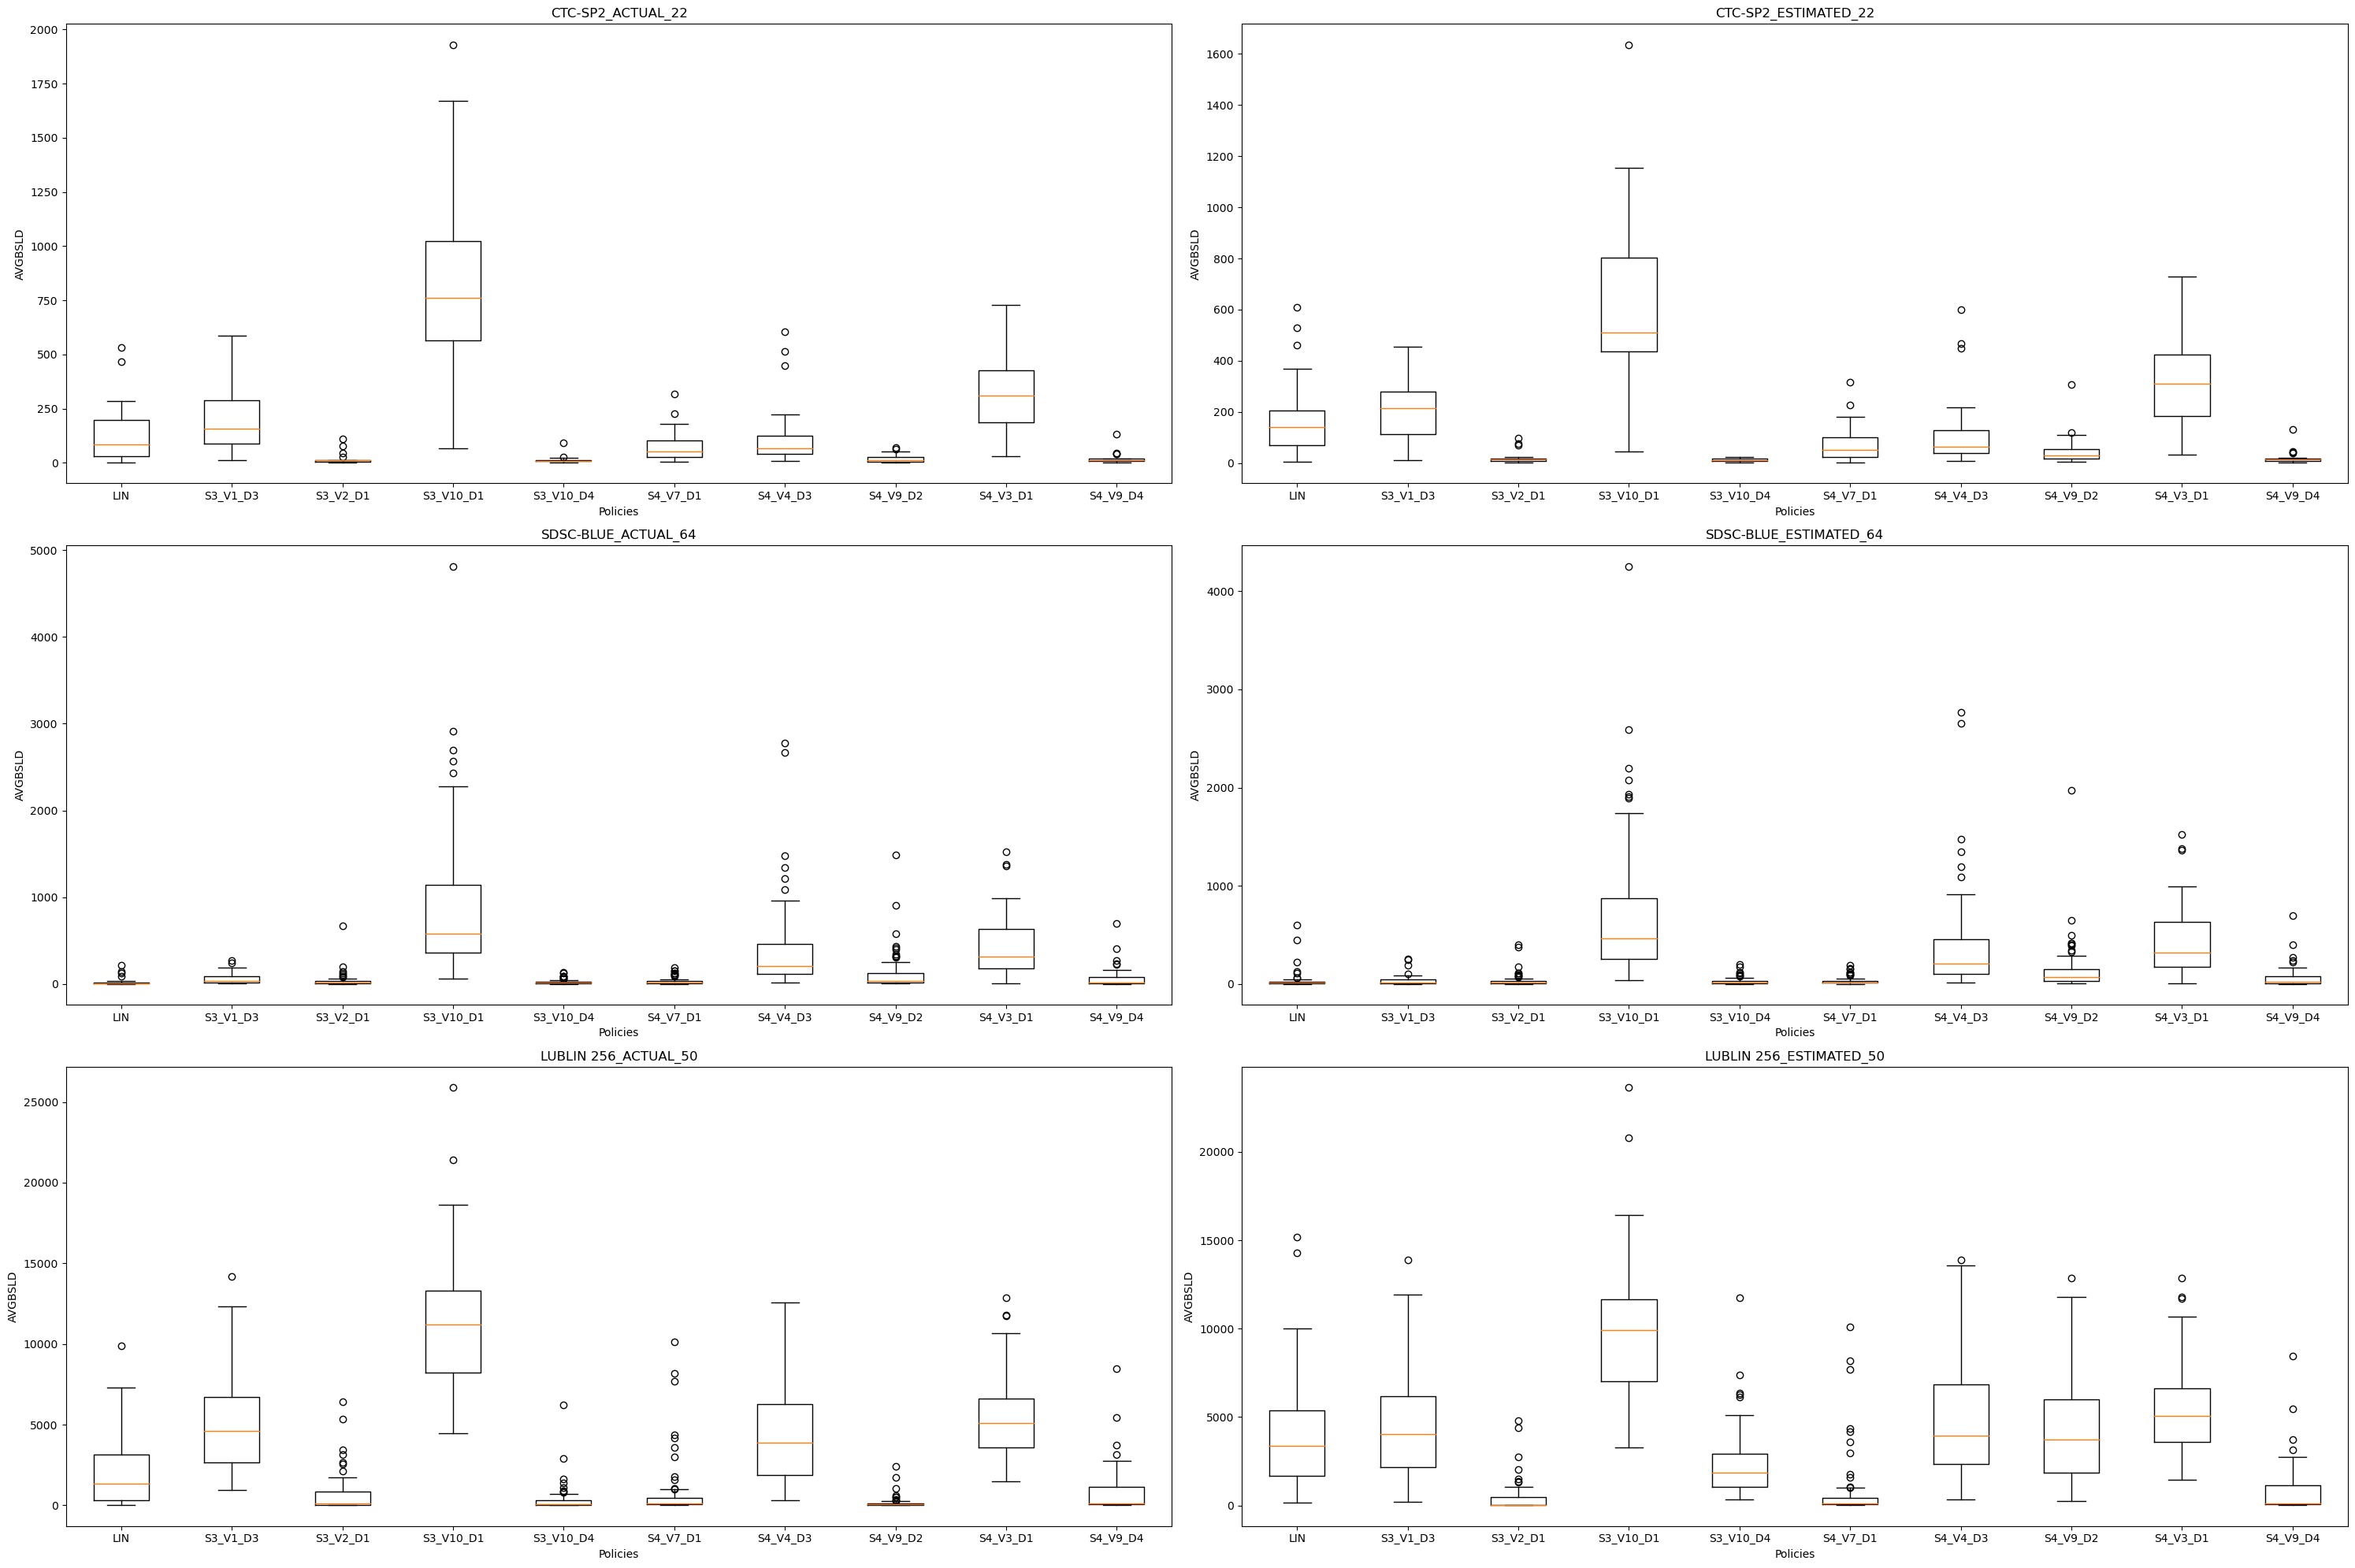

In [32]:
df=[]

# Lire le fichier CSV
df.append(pd.read_csv('src/tester/CTC-SP2_ACTUAL_22_10.csv'))
df.append(pd.read_csv('src/tester/CTC-SP2_ESTIMATED_22_10.csv'))
df.append(pd.read_csv('src/tester/SDSC-BLUE_ACTUAL_64_10.csv'))
df.append(pd.read_csv('src/tester/SDSC-BLUE_ESTIMATED_64_10.csv'))
df.append(pd.read_csv('src/tester/LUBLIN 256_ACTUAL_50_10.csv'))
df.append(pd.read_csv('src/tester/LUBLIN 256_ESTIMATED_50_10.csv'))
title= ['CTC-SP2_ACTUAL_22','CTC-SP2_ESTIMATED_22','SDSC-BLUE_ACTUAL_64','SDSC-BLUE_ESTIMATED_64','LUBLIN 256_ACTUAL_50','LUBLIN 256_ESTIMATED_50']
names=["LIN","S3_V1_D3","S3_V2_D1","S3_V10_D1","S3_V10_D4","S4_V7_D1","S4_V4_D3","S4_V9_D2","S4_V3_D1","S4_V9_D4"]
# Créer une figure avec des sous-graphiques (2 lignes, 3 colonnes)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))
i=0
# Boucle sur chaque subplot
for ax in axes.flatten():
    ax.boxplot(df[i],labels=names)
    ax.set_title(title[i])
    ax.set_xlabel("Policies")
    ax.set_ylabel("AVGBSLD")
    i=i+1

# Ajuster les espaces entre les subplots
plt.tight_layout()

# Sauvegarder la figure dans les deux formats
plt.savefig("images/Corr_analysis_SER.pdf")
plt.savefig("images/Corr_analysis_SER.png")
# Afficher la figure
plt.show()

In [33]:
import pandas as pd

# Lire les données depuis les fichiers CSV
data = []
files = [
    'src/tester/CTC-SP2_ACTUAL_22_10.csv',
    'src/tester/CTC-SP2_ESTIMATED_22_10.csv',
    'src/tester/SDSC-BLUE_ACTUAL_64_10.csv',
    'src/tester/SDSC-BLUE_ESTIMATED_64_10.csv',
    'src/tester/LUBLIN 256_ACTUAL_50_10.csv',
    'src/tester/LUBLIN 256_ESTIMATED_50_10.csv'
]

for file in files:
    data.append(pd.read_csv(file))

# Concaténer les DataFrames
concatenated_df = pd.concat(data)

# Calculer la moyenne de chaque colonne
column_means = concatenated_df.mean()

# Afficher les moyennes
print(column_means)

LIN          1164.351312
S3_V1_D3     1786.410008
S3_V2_D1      257.833541
S3_V10_D1    4468.807476
S3_V10_D4     542.374548
S4_V7_D1      411.896122
S4_V4_D3     1888.208262
S4_V9_D2      920.520924
S4_V3_D1     2285.110092
S4_V9_D4      362.901237
dtype: float64


In [29]:
print(column_means.values)
print(data_mae)

[1164.35131151 1786.41000836  257.83354051 4468.80747622  542.37454758
  411.8961225  1888.20826164  920.52092381 2285.11009167  362.90123726]
[0.21717980982772267, 0.2409854268393933, 0.21693984120016557, 0.21089234508925758, 0.243989158857399, 0.20902869180559244, 0.23105163006866702, 0.21469804751448088, 0.21222638918450404, 0.24586482431455228]


In [28]:
pd.DataFrame(pearsonr(column_means.values,data_mae),index = ['pearson_coeff','p_value'],columns = ['test_result'])

,test_result
pearson_coeff,-0.303186
p_value,0.394456


In [28]:
import seaborn as sns
history=[]
names=[]
print("######################1#######################")
grid_search_2(features,4,1 )




######################1#######################


Progression :: 100%|██████████| 5000/5000 [05:10<00:00, 16.13it/s]

[1.0071730541347763, 1.0115373863525685, 1.0177372457082388, 1.019804719595026, 1.0207844300443942, 1.0246635702341809, 1.0276457553171892, 1.0377376671692264, 1.038257227011376, 1.0391375963883946, 1.041371539942287, 1.0419789863440818, 1.0504849802024852, 1.0524837831526732, 1.0533117803923246, 1.056911278055591, 1.0579565249939673, 1.0670487787404648, 1.0723438260910632, 1.0743698062655054]
[('q1', 'w1', 'p2x', 'z2r'), ('q2', 'p2r', 'z2r', 'w2x'), ('w1', 'p2r', 'z2q', 'x2z'), ('sqrt(p)', 'sqrt(w)', 'x2', 'z2q'), ('p1', 'w1', 'x2', 'z2q'), ('sqrt(x)', 'q1w', 'p2x', 'z2q'), ('x2', 'p2z', 'w2q', 'r2w'), ('x2p', 'q2r', 'w2q', 'r2z'), ('p1', 'x1w', 'q2z', 'z2w'), ('sqrt(q)', 'w1', 'p1x', 'z2r'), ('w1', 'q2p', 'p2x', 'z2q'), ('q1', 'p2', 'z2p', 'x2w'), ('sqrt(w)', 'p2q', 'x2w', 'z2x'), ('sqrt(w)', 'p2z', 'z2q', 'w2x'), ('sqrt(q)', 'p1w', 'z2q', 'x2z'), ('sqrt(p)', 'q1w', 'r2p', 'x2z'), ('q2p', 'p2z', 'r2q', 'w2x'), ('sqrt(r)', 'x2p', 'p2z', 'q2x'), ('p2r', 'w2p', 'r2q', 'z2x'), ('sqrt(w)'

In [29]:
history=[]
names=[]
print("######################2#######################")
grid_search_2(features,4,2 )


######################2#######################


Progression :: 100%|██████████| 5000/5000 [05:55<00:00, 14.08it/s]

[2.001753016495575, 2.0017991875425776, 2.0050789015281225, 2.005521424060463, 2.0063357134138236, 2.007701720786509, 2.0113368451940064, 2.016840377178346, 2.025451620993881, 2.025915302657463, 2.0278519503968724, 2.0336975410532867, 2.0350511597503407, 2.042495517595455, 2.043384865045361, 2.053905005369894, 2.0584825417828982, 2.066340469337777, 2.070201224137037, 2.07185132768973]
[('r2p', 'q2x', 'q2w', 'r2z'), ('sqrt(p)', 'w1', 'q2r', 'w2r'), ('q1', 'q1z', 'r1x', 'z2x'), ('p1r', 'r1x', 'r1z', 'x2w'), ('x2', 'x1w', 'w1z', 'x2q'), ('z2', 'x1z', 'p2z', 'z2q'), ('sqrt(r)', 'w1', 'p1x', 'p2q'), ('sqrt(x)', 'z2', 'q1w', 'q2x'), ('sqrt(w)', 'x1', 'q2z', 'z2q'), ('sqrt(z)', 'w2', 'p1x', 'w2q'), ('r1', 'x2', 'z2', 'x2q'), ('sqrt(x)', 'x2', 'r2p', 'x2w'), ('sqrt(r)', 'z2p', 'q2x', 'q2w'), ('r1w', 'r2p', 'r2q', 'w2z'), ('x1', 'p2', 'x1z', 'x2z'), ('p1z', 'p2r', 'r2x', 'w2z'), ('r1w', 'x2q', 'w2r', 'x2z'), ('p1x', 'q2x', 'q2w', 'z2q'), ('sqrt(z)', 'p1q', 'p1r', 'q1x'), ('sqrt(w)', 'p1z', 'r2p

In [30]:
history=[]
names=[]
print("######################3#######################")
grid_search_2(features,4,3 )

######################3#######################


Progression :: 100%|██████████| 5000/5000 [06:08<00:00, 13.57it/s]

[3.001448603537554, 3.0018329548981364, 3.0026734576083727, 3.003448576995119, 3.005282031800789, 3.005861906641094, 3.0065061058077895, 3.012471174162681, 3.017653338812447, 3.03274926319941, 3.0580895758452704, 3.064657147879429, 3.0738470675222573, 3.080414712114192, 3.097534037964135, 3.097534606968791, 3.0986555889504355, 3.1092187165433427, 3.121980548323228, 3.123279508794355]
[('p2r', 'w2p', 'z2r', 'z2x'), ('p2w', 'q2w', 'z2r', 'z2x'), ('q2', 'z2r', 'w2x', 'z2x'), ('r1', 'q1z', 'r1x', 'z2q'), ('p2', 'r2', 'z2', 'p2r'), ('r1', 'r2p', 'z2p', 'x2q'), ('r1', 'r1x', 'p2z', 'z2q'), ('w1z', 'r2p', 'z2p', 'w2z'), ('q2', 'p1q', 'q1z', 'z2r'), ('z1', 'p1q', 'p1z', 'r1z'), ('sqrt(q)', 'p1z', 'z2r', 'z2x'), ('z1', 'r1z', 'x1w', 'q2p'), ('sqrt(x)', 'z2', 'x1z', 'p2z'), ('r1', 'w1z', 'q2p', 'w2x'), ('z1', 'q1r', 'r1w', 'x2w'), ('p1', 'r1z', 'q2x', 'r2x'), ('q1z', 'p2x', 'z2q', 'r2z'), ('z1', 'x1w', 'p2q', 'x2w'), ('sqrt(x)', 'p1q', 'r1w', 'p2q'), ('r2p', 'z2p', 'w2x', 'z2w')]


In [32]:
history=[]
names=[]
print("######################4#######################")
grid_search_2(features,4,4 )

######################4#######################


Progression :: 100%|██████████| 5000/5000 [05:53<00:00, 14.14it/s]

[4.0016615059252025, 4.0017748252123155, 4.007849326282283, 4.0129671615479685, 4.013335556960589, 4.014777356045461, 4.0216393156414645, 4.0538600058604795, 4.065535372440092, 4.070263962746913, 4.072416899451295, 4.104429303507691, 4.105112162150548, 4.145022149846673, 4.145984664538487, 4.169699754358808, 4.243972670419903, 4.357317324644466, 4.438606508348989, 4.4832542754567255]
[('q1', 'q1x', 'w2p', 'r2w'), ('q1', 'w1', 'q1x', 'w2p'), ('sqrt(q)', 'sqrt(w)', 'p1q', 'q2w'), ('sqrt(w)', 'sqrt(z)', 'p1', 'w2x'), ('sqrt(r)', 'sqrt(x)', 'q1x', 'w2p'), ('z2', 'r1x', 'x2q', 'z2w'), ('w2p', 'r2x', 'w2r', 'z2x'), ('sqrt(r)', 'sqrt(w)', 'x2', 'x2r'), ('sqrt(r)', 'z1', 'q1r', 'w2r'), ('w2', 'p1x', 'q1r', 'q2z'), ('q2', 'r2', 'w2q', 'r2z'), ('sqrt(q)', 'x2', 'p1x', 'p2x'), ('w1', 'p1x', 'p1w', 'p2w'), ('r1z', 'p2r', 'z2p', 'z2w'), ('x2', 'p1r', 'r1z', 'z2w'), ('sqrt(x)', 'q1z', 'r1w', 'r2w'), ('x1z', 'w1z', 'x2w', 'x2z'), ('p1z', 'x2w', 'w2x', 'w2z'), ('r1', 'q1r', 'r1w', 'p2x'), ('sqrt(w)', 

In [33]:
print("######################5#######################")
grid_search_2(features,4,5 )

######################5#######################


Progression :: 100%|██████████| 5000/5000 [05:15<00:00, 15.82it/s]

[5.001909199365414, 5.002064746911906, 5.007220955910219, 5.007281674550008, 5.012731937888864, 5.065518392572909, 5.0891206133276405, 5.093939824831389, 5.134517295843539, 5.171591695939989, 5.258491721837113, 5.275193480379023, 5.279284177308848, 5.31570157979282, 5.317978960521769, 5.3239111726706, 5.362383597481521, 5.3644077554586085, 5.388072578337106, 5.5037563093738955]
[('r1', 'z2', 'r1w', 'p2q'), ('p1w', 'r1x', 'r2x', 'z2r'), ('r2', 'x1w', 'r2q', 'r2w'), ('p2', 'q1r', 'r1w', 'q2z'), ('r2', 'q1r', 'p2r', 'q2z'), ('x1', 'x2r', 'r2z', 'z2w'), ('p2q', 'p2x', 'z2r', 'z2w'), ('p2w', 'q2z', 'z2r', 'z2w'), ('z2', 'p2z', 'z2q', 'r2z'), ('sqrt(r)', 'sqrt(x)', 'x1w', 'r2z'), ('x1w', 'r2p', 'z2r', 'z2w'), ('sqrt(x)', 'sqrt(z)', 'z2', 'p1q'), ('r2', 'q1x', 'r2w', 'z2r'), ('r2', 'p1x', 'r1z', 'w2p'), ('p1', 'r2', 'r1z', 'q2p'), ('sqrt(q)', 'r2', 'r1z', 'w2q'), ('p1', 'r2', 'r1z', 'z2q'), ('sqrt(w)', 'sqrt(z)', 'p1x', 'r1z'), ('sqrt(r)', 'sqrt(x)', 'z2', 'x1z'), ('sqrt(w)', 'z1', 'r1z', 'x1

In [34]:
print("######################6#######################")
grid_search_2(features,4,6 )

######################6#######################


Progression :: 100%|██████████| 5000/5000 [04:56<00:00, 16.87it/s]

[6.009526062762847, 6.0160128006902625, 6.021903004826133, 6.028542190179751, 6.029166674179617, 6.030755477736484, 6.060532150292422, 6.101306467328559, 6.153783206450739, 6.166180710067725, 6.282350930842197, 6.376859976382505, 6.4011473441789555, 6.492538379768942, 6.535144401520387, 6.598280069977124, 6.988513071086951, 7.734750971970649, 7.827003518184426, 7.8369997657863495]
[('q1z', 'p2r', 'x2q', 'q2z'), ('p1z', 'r1z', 'q2w', 'w2q'), ('p2', 'q1z', 'p2z', 'q2z'), ('sqrt(q)', 'sqrt(r)', 'z1', 'p1z'), ('sqrt(z)', 'p2r', 'q2w', 'w2q'), ('sqrt(q)', 'sqrt(x)', 'p1q', 'p2q'), ('x1', 'r2', 'r2z', 'z2x'), ('p1z', 'r2x', 'r2z', 'z2w'), ('z2', 'x1w', 'q2w', 'w2q'), ('sqrt(q)', 'q1', 'p1r', 'q2w'), ('sqrt(w)', 'z1', 'z2', 'r1w'), ('r2', 'p1z', 'r1z', 'x1z'), ('p1z', 'x2q', 'q2w', 'w2q'), ('q1z', 'q2p', 'q2z', 'w2z'), ('p1q', 'q1r', 'q2r', 'w2x'), ('sqrt(q)', 'q1', 'q1z', 'x1z'), ('r1', 'z2', 'q1z', 'r2z'), ('w2p', 'q2r', 'x2q', 'q2z'), ('q1', 'q1r', 'q1z', 'z2w'), ('sqrt(x)', 'sqrt(w)', 'x1

In [35]:
print("######################7#######################")
grid_search_2(features,4,7 )

######################7#######################


Progression :: 100%|██████████| 5000/5000 [04:55<00:00, 16.94it/s]

[7.008628818124605, 7.035559897464706, 7.044025776646811, 7.098912463617953, 7.1062464577159, 7.116248694857417, 7.153906341394767, 7.2390372394375575, 7.331443720042881, 7.333070767218341, 7.430913992773097, 7.5057770358302385, 7.7401295068028775, 7.819919920825129, 7.842614648947466, 8.017443288607327, 8.059077434299452, 8.097941055007286, 8.241792488153017, 8.365769322639666]
[('sqrt(x)', 'x1w', 'w2x', 'z2w'), ('r1', 'x1', 'z2', 'r2z'), ('sqrt(x)', 'sqrt(w)', 'p2x', 'p2z'), ('x1', 'q1r', 'q1w', 'q2r'), ('sqrt(r)', 'sqrt(x)', 'z2', 'r1w'), ('sqrt(q)', 'q1', 'p1q', 'z2q'), ('sqrt(x)', 'sqrt(w)', 'r1z', 'w2q'), ('z2', 'p1x', 'r2w', 'z2w'), ('sqrt(q)', 'sqrt(x)', 'sqrt(w)', 'p2z'), ('sqrt(w)', 'z1', 'r2', 'r2w'), ('sqrt(q)', 'q1', 'q1x', 'w2z'), ('x1w', 'w2p', 'q2w', 'w2q'), ('p2w', 'q2r', 'q2z', 'w2z'), ('sqrt(w)', 'w1', 'z2', 'r2p'), ('sqrt(x)', 'sqrt(w)', 'q1', 'x1z'), ('sqrt(p)', 'p1', 'x1w', 'x2p'), ('p2r', 'q2r', 'q2w', 'w2q'), ('w1', 'p2', 'q1r', 'q1z'), ('sqrt(r)', 'q1x', 'r2p',

In [37]:
print("######################8#######################")
grid_search_2(features,4,8 )

######################8#######################


Progression :: 100%|██████████| 5000/5000 [05:10<00:00, 16.10it/s]

[8.003473687245577, 8.011373287100955, 8.011825045354312, 8.022351242636304, 8.03311807573905, 8.110131747833956, 8.125229357934352, 8.275528788606401, 8.376156415642319, 8.432093776814941, 8.447239767162008, 8.469521207011603, 8.707549829092137, 8.76109297296522, 8.858322632647578, 9.099899257445303, 9.438791889677507, 9.449705289457226, 9.484648644452605, 9.801617955860962]
[('sqrt(q)', 'sqrt(z)', 'z1', 'r1w'), ('q1x', 'q2p', 'q2r', 'q2x'), ('sqrt(r)', 'sqrt(w)', 'x2', 'r1x'), ('sqrt(w)', 'w1', 'q2p', 'x2q'), ('sqrt(r)', 'r2', 'r2x', 'x2z'), ('sqrt(w)', 'w1', 'p1z', 'x2q'), ('x1', 'q2r', 'q2w', 'w2q'), ('sqrt(z)', 'w1', 'z1', 'z2r'), ('q1', 'q2', 'q2x', 'w2z'), ('r1', 'p1q', 'r1w', 'w2z'), ('sqrt(z)', 'p1r', 'p1z', 'z2q'), ('z2', 'q1w', 'z2r', 'x2z'), ('q1', 'q2', 'r1x', 'q2x'), ('sqrt(z)', 'q1r', 'q2r', 'w2q'), ('sqrt(q)', 'r1', 'z1', 'p2x'), ('x2', 'p1r', 'p1z', 'r2z'), ('w2', 'p1r', 'p1z', 'r2w'), ('r1x', 'x1z', 'p2x', 'q2z'), ('r2', 'p1r', 'p1z', 'q2x'), ('r1x', 'x1z', 'x2p', 'z2

In [38]:
print("######################9#######################")
grid_search_2(features,4,9 )

######################9#######################


Progression :: 100%|██████████| 5000/5000 [04:54<00:00, 16.95it/s]

[9.027708950375395, 9.029719879417215, 9.040591028317369, 9.041235306711272, 9.042312582677937, 9.065636579977523, 9.212886067723966, 9.252388733367198, 9.347318670354825, 9.388310746221393, 9.412873215976624, 9.446766724687985, 9.501795229954057, 9.822659514464311, 9.897806133529715, 10.569371948673327, 10.60134062096243, 10.864192056979451, 12.864156351133133, 13.032761466938322]
[('p1r', 'p1z', 'q1w', 'x2q'), ('sqrt(p)', 'p1', 'r1x', 'p2q'), ('r2', 'z2', 'q2r', 'z2r'), ('r1', 'z1', 'q1x', 'r2q'), ('w1', 'p1r', 'p1z', 'q1w'), ('sqrt(q)', 'p1r', 'p1z', 'x1w'), ('p1r', 'p1z', 'q1z', 'w2x'), ('r2', 'r1z', 'q2w', 'r2w'), ('sqrt(w)', 'x1', 'x2', 'z2'), ('sqrt(p)', 'sqrt(w)', 'w1', 'q2'), ('p1q', 'q2p', 'x2p', 'p2w'), ('p1r', 'p1z', 'r1x', 'r2w'), ('p1r', 'p1z', 'x1z', 'x2r'), ('r1w', 'w1z', 'p2r', 'z2p'), ('q1', 'q1x', 'w1z', 'x2q'), ('sqrt(p)', 'sqrt(z)', 'p1', 'r1'), ('sqrt(w)', 'w1', 'q1w', 'q2x'), ('sqrt(p)', 'r1', 'z1', 'w1z'), ('r1w', 'r1z', 'q2w', 'z2r'), ('sqrt(q)', 'sqrt(r)', 'q1

In [39]:
print("######################10#######################")
grid_search_2(features,4,10 )

######################10#######################


Progression :: 100%|██████████| 5000/5000 [04:07<00:00, 20.22it/s]

[10.015880707426877, 10.045044667124959, 10.077742111598297, 10.08520797417565, 10.09196414655722, 10.113232563755586, 10.159402335830517, 10.230617121866493, 10.302066395227145, 10.450195112865604, 10.647966872799987, 10.698435500119974, 10.791400802971708, 10.793066114602636, 11.235271491856558, 11.741845143723499, 12.416875095456017, 12.97513165182763, 14.583819666653445, 15.093969712700465]
[('r2', 'z2', 'r1w', 'z2r'), ('r1', 'q1r', 'z2p', 'q2r'), ('q1x', 'p2r', 'p2z', 'q2r'), ('p2r', 'w2p', 'p2z', 'w2x'), ('r1', 'z1', 'r2w', 'w2x'), ('sqrt(r)', 'q2p', 'p2r', 'p2z'), ('r1z', 'p2r', 'p2z', 'x2w'), ('p1w', 'p2q', 'p2r', 'p2z'), ('x1w', 'p2r', 'r2p', 'p2z'), ('r1', 'z1', 'p2', 'r1z'), ('sqrt(w)', 'w1', 'q1x', 'w2r'), ('z2', 'x2r', 'r2w', 'z2r'), ('sqrt(w)', 'w1', 'p1x', 'w2p'), ('sqrt(w)', 'w1', 'q1x', 'w2z'), ('r1', 'r1w', 'p2q', 'w2r'), ('z1', 'p1r', 'r1w', 'w1z'), ('sqrt(r)', 'sqrt(w)', 'x1', 'z1'), ('sqrt(x)', 'x1', 'p2x', 'r2z'), ('sqrt(x)', 'x1', 'z1', 'q2x'), ('sqrt(p)', 'p1', 

In [12]:
history=[]
names=[]
grid_search(features,2 )
plt.figure(figsize=(40, 10))
data=pd.DataFrame(zip(history,names),columns=['VIF','NAME'])
data=data.sort_values('VIF')

Progression :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 630/630 [00:11<00:00, 56.43it/s]

[1.0000000687381108, 1.0000003845348913, 1.0000007016175474, 1.0000009714029523, 1.000001195608339]
[('p4', 'r4q'), ('p4', 'r3q'), ('r4', 'p4q'), ('p4q', 'r4q'), ('p4', 'r4')]


<Figure size 4000x1000 with 0 Axes>

In [29]:
print(9**(1/4))

1.7320508075688772


In [33]:
print(np.max(compute_vif(features)["VIF"]))

1.2727812286448872


In [119]:
compute_vif(features['p']*features['q'])


IndexError: tuple index out of range

In [21]:
p=[]
for i in range (2,3):
    p.append(Process(target=grid_search,args=(features,i)))
    p[i-2].start()
    
for proc in p:
    proc.join()
    
        

Progression: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 435/435 [00:35<00:00, 12.22it/s]


1.2862065211525044
('r3q', 'r4p')


In [ ]:
res=only_lin_predictors_pr(features)
vif=compute_vif(res)
print (vif)
print("mean = ",np.mean(vif.VIF))

In [ ]:
compute_vif(create_quadratic_polynomial(features))

In [ ]:
compute_vif(create_cubic_polynomial(features))

In [ ]:
compute_vif(create_quartic_polynomial(features))

In [ ]:
compute_vif(create_quintic_polynomial(features))

In [ ]:
compute_vif(features)